# Problem 1

## (a) Finite difference for European options (explicit)

We start with the Black-Scholes PDE for an European call, $C(S, t)$:

$$\frac{\partial C}{\partial t} + r S \frac{\partial C}{\partial S} + \frac{\sigma^2 S^2}{2} \frac{\partial^2 C}{\partial S^2} - r C = 0$$

We follow Section 3.4 of the textbook. First we set $x = \log S$ so that we can remove the non-linearities, since eg.

$$S \frac{\partial C}{\partial S} = \frac{\partial C}{\partial x}.$$

The equation now becomes
$$\frac{\partial C}{\partial t} + \nu \frac{\partial C}{\partial x} + \frac{\sigma^2}{2} \frac{\partial^2 C}{\partial x^2} - r C = 0$$

where $\nu = r - \sigma^2/2$ (including a $-\delta$ term in case ov dividends).

For a call option, the "theoretical" boundary conditions are as follows:
* $C(S, t=T) = (S-K)^+$ for all $S \in [0, \infty[$
* $C(S=0, t) = 0$ for all $t \in [0,T]$ (option completly OTM)
* $C(S \to \infty, t) \to S$ for all $t \in [0,T]$ (option is as worthy as the asset itself)

whereas for a put one has formally the same equation, but

* $P(S, t=T) = (K-S)^+$ for all $S \in [0, \infty[$
* $P(S=0, t) = S$ for all $t \in [0,T]$ (option is as worthy as the asset itself)
* $P(S \to \infty, t) \to 0$ for all $t \in [0,T]$ (option completly OTM)




The disadvantage of going to log space is that we need to define a second finite-difference step $\Delta x$ (if we had stayed with $S$, these would have cancelled out). **We choose**

$$\Delta x = \alpha \sigma \sqrt{3 \Delta t}$$

for $\alpha \geq 1$, in order to ensure convergence and stability.

Since we want to go back in time (as we know the final conditions but not the initial ones) we discretize $C = C(t=i\Delta t, x=j\Delta x)$ and write $C_{i,j}$ as a function of $C_{i+1,*}$. To avoid having to consider more than one time step, we discretize the time derivative with a forward difference; for $x$ derivatives we use centered differences. We then have

$$\begin{align*}
\frac{\partial C}{\partial t}(i\Delta t, j\Delta x) &\approx \frac{C_{i+1,j} - C_{i,j}}{\Delta t }\\
\frac{\partial C}{\partial S}(i\Delta t, j\Delta x) &\approx \frac{C_{i+1,j+1} - C_{i+1,j-1}}{2\Delta x}\\
\frac{\partial^2 C}{\partial S^2}(i\Delta t, j\Delta x) &\approx \frac{C_{i+1,j+1} -2 C_{i+1,j} + C_{i+1,j-1}}{(\Delta x)^2}
\end{align*}$$

$$- \frac{C_{i+1,j} - C_{i,j}}{\Delta } = r C_{i+1, j} + \nu  \left( \frac{C_{i+1,j+1} - C_{i+1,j-1}}{2\Delta x} \right) + \frac{\sigma^2}{2} \left(\frac{C_{i+1,j+1} -2 C_{i+1,j} + C_{i+1,j-1}}{(\Delta x)^2} \right)\quad(1)$$

*Explicitly* writing $C_{i,j}$ as a function of the other terms yields:

$$C_{i,j} = p_u C_{i+1, j+1} + p_m C_{i+1, j} + p_d C_{i+1, j-1}$$
with 
$$\begin{align*}
p_u &= \Delta t \left( \frac{\sigma^2}{2\Delta x^2} + \frac{\nu}{2\Delta x}\right)\\
p_m &= 1 -  \Delta t \frac{\sigma^2}{\Delta x^2} -r\Delta t\\
p_d &= \Delta t \left( \frac{\sigma^2}{2\Delta x^2} - \frac{\nu}{2\Delta x}\right)
\end{align*}$$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def explicit_fd_euro(T, K, S0, r, div, sigma, N_timesteps, N_xsteps, option_type):
    
    def payoff(s, K):
        if option_type == 'call':
            return max(s-K, 0)
        elif option_type == 'put':
            return max(K-s, 0)
        else:
            raise Exception("Bad option type")
            
    # constants
    dt = T/N_timesteps
    dx = 1.5 * sigma * np.sqrt(3*dt)
    nu = r - div - sigma**2/2
    edx = np.exp(dx)
    pu = dt * (sigma**2/(2*dx**2) + nu/(2*dx))
    pm = 1 - dt * sigma**2/(dx**2) - r*dt
    pd = dt * (sigma**2/(2*dx**2) - nu/(2*dx))
    
    # as we did in the trinomial tree, first build all spot values 
    # since this is a grid, we have no need to evolve them backwards
    St = np.zeros(2*N_xsteps + 1)
    St[0] = S0*np.exp(-N_xsteps*dx)
    for j in range(1,2*N_xsteps+1):
        St[j] = St[j-1]*edx
    
    # boundary values for the option: payoff
    C = np.zeros((N_timesteps+1, 2*N_xsteps+1))
    for j in range(2*N_xsteps+1):
        C[N_timesteps, j] = payoff(St[j], K)
        
    # propagate back
    for i in range(N_timesteps-1, -1, -1):
        
        # finite difference evolution
        for j in range(1, 2*N_xsteps):
            C[i,j] = pu*C[i+1,j+1] + pm*C[i+1,j] + pd*C[i+1,j-1]
        
        # boundary conditions
        if option_type == 'call':
            C[i, 0] = C[i, 1]
            C[i, 2*N_xsteps] = C[i, 2*N_xsteps-1] + (St[2*N_xsteps] - St[2*N_xsteps-1])
        else:
            C[i, 0] = C[i, 1] + (St[1] - St[0])
            C[i, 2*N_xsteps] = C[i, 2*N_xsteps-1] 
            
            
    return C[0,N_xsteps]

**Test**: put-call parity

$C(t) - P(T)$:

In [5]:
call_price = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0, sigma=0.2, N_timesteps=200, N_xsteps=100, option_type="call")
print("Call: %.2f" % call_price)

Call: 10.96


In [6]:
put_price = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0, sigma=0.2, N_timesteps=200, N_xsteps=100, option_type="put")
print("Put: %.2f" % put_price)

Put: 5.14


In [7]:
print("C-P: %.2f" % (call_price - put_price))

C-P: 5.83


$S_0  - K e^{-r(T-t)}$:

In [8]:
print("S(t)-K_disc: %.2f" % (100 - np.exp(-0.06*(1.0))*100))

S(t)-K_disc: 5.82


It works.

## (b) Finite differences for European options (implicit)

In this context, we change the time of the RHS of equation $(1)$ from $i+1$ to $i$:

$$- \frac{C_{i+1,j} - C_{i,j}}{\Delta t} = r C_{i+1, j} + \nu  \left( \frac{C_{i,j+1} - C_{i,j-1}}{2\Delta x} \right) + \frac{\sigma^2}{2} \left(\frac{C_{i,j+1} -2 C_{i,j} + C_{i,j-1}}{(\Delta x)^2} \right)\quad(1)$$

We now need to solve the *implicit* system of equations:

$$p_u C_{i,j+1} + p_m C_{i, j} + p_d C_{i, j-1} = C_{i+1, j}$$
with 
$$\begin{align*}
p_u &= - \frac 12 \Delta t \left( \frac{\sigma^2}{\Delta x^2} + \frac{\nu}{\Delta x}\right)\\
p_m &= 1 +  \Delta t \frac{\sigma^2}{\Delta x^2} + r\Delta t\\
p_d &= - \frac 12 \Delta t \left( \frac{\sigma^2}{\Delta x^2} - \frac{\nu}{\Delta x}\right)
\end{align*}$$

The system is tridiagonal. In Python, we use the `scipy.linalg.solve_banded` function, which requires us to translate the tridiagonal matrix $A$ in $Ax = b$ into a matrix containing only the tridiagonal elements (see documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html#scipy.linalg.solve_banded)

$$A \equiv \begin{pmatrix}
1      & -1     & 0      & \cdots & \cdots & \cdots & 0\\
p_u    & p_m    & p_d    & 0      & \cdots & \cdots & 0\\
0      & p_u    & p_m    & p_d    & 0      & \cdots & 0\\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots\\
0      & \cdots & \cdots & 0      & p_u    & p_m    & p_d \\
0      & \cdots & \cdots & \cdots & 0      & 1      & -1
\end{pmatrix}
\rightarrow
band = \begin{pmatrix}
*   & -1  & p_d & p_d & \cdots & p_d & p_d & p_d \\
1   & p_m & p_m & p_m & \cdots & p_m & p_m & -1  \\
p_u & p_u & p_u & p_u & \cdots & p_u & 1   & * 
\end{pmatrix}$$

The system we want to solve is:
$$A \cdot C[i, j \in 0:2 N + 1] = [\lambda_U, C[i+1, j \in 1:2N], \lambda_L]^T$$

where $C[i, j \in 0:2 N + 1]$ is the "$C_i$" full vector with $2N+1$ entries, whereas the RHS is its $2N-1$ central components augmented with boundary condition terms.

In [55]:
def solve_tridiagonal(lambda_u, lambda_l, C, pu, pm, pd):
    from scipy.linalg import solve_banded
    """
    Receives a vector C with 2N+1 components, substitutes the edge points
    with the correct boundary conditions, and returns another 2N+1-long 
    vector C' solving the equation AC' = C.
    """
    length = len(C)
    assert length > 3, "Vector is not long enough"
    # build matrix band 
    first_row = [0, -1] + [pd]*(length-2)
    second_row = [1] + [pm]*(length-2) + [-1]
    third_row = [pu]*(length-2)+[1,0]
    
    band = np.array([first_row,
                     second_row,
                     third_row])
    
    C = C.copy()
    C[0], C[-1] = lambda_u, lambda_l
    
    return solve_banded((1,1), band, C)

### Testing our solver

In [56]:
pu=0.3; pm=0.5; pd=0.2

In [57]:
x = solve_tridiagonal(20, 15, np.array([1,2,3,4]), pu=0.3, pm=0.5, pd=0.2)

In [58]:
from scipy import linalg
y = linalg.solve(np.array([[1,-1,0,0],[pu, pm, pd, 0],[0, pu, pm, pd],[0, 0, 1,-1]]), np.array([20, 2, 3,15]))

In [59]:
any(x==y)

True

In [62]:
def implicit_fd_euro(T, K, S0, r, div, sigma, N_timesteps, N_xsteps, option_type):
    
    def payoff(s, K):
        if option_type == 'call':
            return max(s-K, 0)
        elif option_type == 'put':
            return max(K-s, 0)
        else:
            raise Exception("Bad option type")
            
    # constants
    dt = T/N_timesteps
    dx = 1.5 * sigma * np.sqrt(3*dt)
    nu = r - div - sigma**2/2
    edx = np.exp(dx)
    pu = -0.5 * dt * (sigma**2/(dx**2) + nu/(dx))
    pm = 1 + dt * sigma**2/(dx**2) + r*dt
    pd = -0.5 * dt * (sigma**2/(dx**2) - nu/(dx))
    
    # as we did in the trinomial tree, first build all spot values 
    # since this is a grid, we have no need to evolve them backwards
    St = np.zeros(2*N_xsteps + 1)
    St[0] = S0*np.exp(-N_xsteps*dx)
    for j in range(1,2*N_xsteps+1):
        St[j] = St[j-1]*edx
    
    # instead of having a matrix C, it is simpler to have two vector versions for 
    # before and after updates
    C = np.zeros(2*N_xsteps+1)
    
    # boundary values for the option: payoff
    for j in range(2*N_xsteps+1):
        C[j] = payoff(St[j], K)
        
    # derivative boundary conditions
    if option_type == 'call':
        lambda_L = 0.0
        lambda_U = St[2*N_xsteps] - St[2*N_xsteps-1]
    else:
        lambda_L = -1 * (St[1] - St[0])
        lambda_U = 0.0
    
    # we need to revert C for it to match the order in the book
    C = C[::-1]
    # propagate back
    for i in range(N_timesteps-1, -1, -1):
        C = solve_tridiagonal(lambda_U, lambda_L, C, pu, pm, pd)

    return C[N_xsteps]

Same test as before:

In [64]:
call_price = implicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0, sigma=0.2, N_timesteps=200, N_xsteps=100, option_type="call")
print("Call: %.2f" % call_price)

Call: 10.95


In [65]:
put_price = implicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0, sigma=0.2, N_timesteps=200, N_xsteps=100, option_type="put")
print("Put: %.2f" % put_price)

Put: 5.13


In [66]:
print("C-P: %.2f" % (call_price - put_price))

C-P: 5.82


$S_0  - K e^{-r(T-t)}$:

In [67]:
print("S(t)-K_disc: %.2f" % (100 - np.exp(-0.06*(1.0))*100))

S(t)-K_disc: 5.82


## (c) Crank-Nicolson

To derive Crank-Nicolson, we consider both the explicit and implicit methods and average them.

Explicit:
$$- \frac{C_{i+1,j} - C_{i,j}}{\Delta t} = r C_{i+1, j} + \nu  \left( \frac{C_{i+1,j+1} - C_{i+1,j-1}}{2\Delta x} \right) + \frac{\sigma^2}{2} \left(\frac{C_{i+1,j+1} -2 C_{i+1,j} + C_{i+1,j-1}}{(\Delta x)^2} \right)$$

Implicit:
$$- \frac{C_{i+1,j} - C_{i,j}}{\Delta t} = r C_{i+1, j} + \nu  \left( \frac{C_{i,j+1} - C_{i,j-1}}{2\Delta x} \right) + \frac{\sigma^2}{2} \left(\frac{C_{i,j+1} -2 C_{i,j} + C_{i,j-1}}{(\Delta x)^2} \right)$$

Sum and divide by 2:

$$- \frac{C_{i+1,j} - C_{i,j}}{\Delta t} = r \frac{C_{i+1, j} + C_{i,j}}{2} +   \frac{\nu}{2} \left( \frac{C_{i+1,j+1} - C_{i+1,j-1}}{2\Delta x} + \frac{C_{i,j+1} - C_{i,j-1}}{2\Delta x} \right) + \frac{\sigma^2}{4} \left(\frac{C_{i+1,j+1} -2 C_{i+1,j} + C_{i+1,j-1}}{(\Delta x)^2}  + \frac{C_{i,j+1} -2 C_{i,j} + C_{i,j-1}}{(\Delta x)^2} \right)$$

Now we collect terms:

$$p_u C_{i,j+1} + p_m C_{i,j} + p_d C_{i,j-1} = - p_u C_{i+1,j+1} - (p_m-2) C_{i+1,j} - p_d C_{i+1,j-1}$$

with
$$\begin{align*}
p_u &= - \frac 14 \Delta t \left( \frac{\sigma^2}{\Delta x^2} + \frac{\nu}{\Delta x}\right)\\
p_m &= 1 +  \Delta t \frac{\sigma^2}{2\Delta x^2} + \frac 12 r\Delta t\\
p_d &= - \frac 14 \Delta t \left( \frac{\sigma^2}{\Delta x^2} - \frac{\nu}{\Delta x}\right)
\end{align*}$$

The tridiagonal solver is exactly the same as before. However, we must change the right-hand-side.

In [80]:
def crank_nicolson_fd_euro(T, K, S0, r, div, sigma, N_timesteps, N_xsteps, option_type):
    
    def payoff(s, K):
        if option_type == 'call':
            return max(s-K, 0)
        elif option_type == 'put':
            return max(K-s, 0)
        else:
            raise Exception("Bad option type")
            
    # constants
    dt = T/N_timesteps
    dx = 1.5 * sigma * np.sqrt(3*dt)
    nu = r - div - sigma**2/2
    edx = np.exp(dx)
    pu = -0.25 * dt * (sigma**2/(dx**2) + nu/(dx))
    pm = 1 + 0.5*dt * sigma**2/(dx**2) + 0.5 * r * dt
    pd = -0.25 * dt * (sigma**2/(dx**2) - nu/(dx))
    
    # as we did in the trinomial tree, first build all spot values 
    # since this is a grid, we have no need to evolve them backwards
    St = np.zeros(2*N_xsteps + 1)
    St[0] = S0*np.exp(-N_xsteps*dx)
    for j in range(1,2*N_xsteps+1):
        St[j] = St[j-1]*edx
    
    # instead of having a matrix C, it is simpler to have two vector versions for 
    # before and after updates
    C = np.zeros(2*N_xsteps+1)
    
    # boundary values for the option: payoff
    for j in range(2*N_xsteps+1):
        C[j] = payoff(St[j], K)
        
    # derivative boundary conditions
    if option_type == 'call':
        lambda_L = 0.0
        lambda_U = St[2*N_xsteps] - St[2*N_xsteps-1]
    else:
        lambda_L = -1 * (St[1] - St[0])
        lambda_U = 0.0
    
    # we need to revert C for it to match the order in the book
    C = C[::-1]
    # propagate back
    for i in range(N_timesteps-1, -1, -1):
        rhs = np.zeros(2*N_xsteps+1)
        for j in range(1,2*N_xsteps):
            rhs[j] = -pu*C[j-1] - (pm-2)*C[j] - pd*C[j+1]
            
        C = solve_tridiagonal(lambda_U, lambda_L, rhs, pu, pm, pd)

    return C[N_xsteps]

Same test as before:

In [81]:
call_price = crank_nicolson_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0, sigma=0.2, N_timesteps=200, N_xsteps=100, option_type="call")
print("Call: %.2f" % call_price)

Call: 10.96


In [82]:
put_price = crank_nicolson_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0, sigma=0.2, N_timesteps=200, N_xsteps=100, option_type="put")
print("Put: %.2f" % put_price)

Put: 5.13


In [83]:
print("C-P: %.2f" % (call_price - put_price))

C-P: 5.82


$S_0  - K e^{-r(T-t)}$:

In [84]:
print("S(t)-K_disc: %.2f" % (100 - np.exp(-0.06*(1.0))*100))

S(t)-K_disc: 5.82


## d) Error estimates

Both the **implicit** and **explicit** methods have convergence speed $O(\Delta t, \Delta x^2)$ whereas Crank-Nicolson has speed $O(\Delta t^2, \Delta x^2)$.


Let us define an error estimate for the explicit/implicit method as
$$\epsilon =  \Delta t + \Delta x^2\quad(*)$$
NOTE: this is not dimensionless, but has units of time + number. So any analysis here should be taken with a grain of salt.

We will use the best estimates provided in the book: 
$$ \Delta t = \frac{1}{3} \left(\frac{\Delta x}{\sigma}\right)^2 \quad(**)$$

Joining this back into $(*)$ yields
$$\epsilon = \Delta x^2 \left(1 + \frac{1}{3 \sigma^2}\right)\Rightarrow \boxed{\Delta x_{implicit/explicit} = \sqrt{\frac{\epsilon}{1 + {1}/{3 \sigma^2}}}}$$

For **Crank-Nicolson**, we change $(*)$ into 
$$\epsilon = \Delta t^2 + \Delta x^2$$

which, by using $(**)$ again, yields
$$\frac{1}{9\sigma^4} (\Delta x)^4 + (\Delta x)^2 - \epsilon = 0$$

This is a quadratic equation for $(\Delta x)^2$, which can be solved as
$$\boxed{\Delta x_{C-K} = \sqrt{- \frac{9\sigma^4}{2} +\sqrt{ \left( \frac{9\sigma^4}{2} \right)^2 + {9\sigma^4 \epsilon}}}}$$

In any case, solving for $\Delta x$ above we can find $\Delta t$ from $(**)$; then, since 

$$N = \frac{T}{\Delta T}$$

we can immediately identify the number of time steps. Finally, we choose the number of space points $N_j$ by imposing
$$\boxed{N \geq 3 \left(\frac{2 N_j+1}{n_{SD}}\right)^2}$$

where $n_{SD}$ is chosen as at least 15. This yields

$$\boxed{N_j \approx \frac{1}{2} \left(15 \sqrt{\frac{N}{3}} - 1\right)}$$

## e) Comparing methods

In [85]:
S0 = 100
K = 100
T = 1
sigma = 0.20
r = 0.06
div = 0.02

In [87]:
eps = 1e-4  # error requested

**Parameters for explicit method**

In [129]:
dx = np.sqrt(eps/(1+1/(3*sigma**2)))
dt = dx**2/(3*sigma**2)

In [130]:
N = int(np.floor(T/dt))
Nj = int(np.floor(0.5*(15*np.sqrt(N/3)-1)))
print(f"Explicit/implicit: N = {N}, Nj = {Nj}")

Explicit/implicit: N = 11200, Nj = 457


**Parameters for Crank-Nicolson**

In [131]:
aux = 9*sigma**4/(2*1**2)
dx = np.sqrt(-aux + np.sqrt(aux**2 + 9*sigma**4 *eps/(1**2)))
dt = dx**2/(3*sigma**2)

In [132]:
N_CK = int(np.floor(T/dt))
Nj_CK = int(np.floor(0.5*(15*np.sqrt(N_CK/3)-1)))
print(f"Crank-Nicolson: N = {N_CK}, Nj = {Nj_CK}")

Crank-Nicolson: N = 1208, Nj = 149


**Comparing methods**

In [128]:
call = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="call")
put = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="put")
print(f"Explicit:\t call = {round(call, 4)}, put = {round(put, 4)}")

call = implicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="call")
put = implicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="put")
print(f"Implicit:\t call = {round(call, 4)}, put = {round(put, 4)}")

call = crank_nicolson_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N_CK, N_xsteps=Nj_CK, option_type="call")
put = crank_nicolson_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N_CK, N_xsteps=Nj_CK, option_type="put")
print(f"Crank-Nicolson:\t call = {round(call, 4)}, put = {round(put, 4)}")

Explicit:	 call = 9.7281, put = 5.8846
Implicit:	 call = 9.7279, put = 5.8845
Crank-Nicolson:	 call = 9.7235, put = 5.88


## f) Numerical parameter estimation

Copying Black-Scholes code from HW1, and editing to include dividends:

In [116]:
def bsm_value(S, K, T, r, div, sigma, option_type):  # T here stands for time to maturity
    from scipy import stats
    assert option_type in ['put', 'call'], "Invalid option type"
    
    phi = 1 if option_type == 'call' else -1  # multiplication factor to adjust for option type
    
    N = lambda x: stats.norm.cdf(x, loc=0.0, scale=1.0)
    d1 = 1 if T == 0 else (np.log(S/K) + (r - div + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    return phi*(np.exp(-div*T) * S * N(phi*d1) - K * np.exp(-r*T) * N(phi*d2))

Theoretical values:

In [119]:
call_bsm = bsm_value(S=100, K=100, r=0.06, div=0.02, sigma=0.2, T=1.0, option_type='call')
put_bsm = bsm_value(S=100, K=100, r=0.06, div=0.02, sigma=0.2, T=1.0, option_type='put')
print(f"Black-Scholes:\t call = {round(call_bsm, 4)}, put = {round(put_bsm, 4)}")

Black-Scholes:	 call = 9.7285, put = 5.8851


We build our empirical parameter estimator as follows:

* Starting with a given $N$, we derive $N_j$ from ${N_j \approx \frac{1}{2} \left(15 \sqrt{\frac{N}{3}} - 1\right)}$

* Then, we derive $\Delta t = T/N$ and $\Delta x = \alpha \sigma \sqrt{3 \Delta t}$ for $\alpha > 1$ (in practice we choose 1.5)

* We calculate the error by comparing with the BSM value

* If we haven't reached the error yet, we increase $N$ 

#### Important disclaimer
For an error like $10^{-4}$ as requested, the code is taking a significant amount of time (because it requires N larger than 100,000). Due to time feasibility, we decided to work with a different error of $10^{-3}$

In [178]:
def estimate_parameters(true_solution,
                        solver,
                        error_target,
                        model_params_dict):
    N, error = 1, np.infty
    while error > error_target:
        N *= 2
        Nj = int(np.ceil(0.5 * (15*np.sqrt(N/3) -1)))
        sol = solver(**model_params_dict, N_timesteps=N, N_xsteps=Nj)
        dt = T/N
        dx = 1.5 * model_params_dict['sigma'] * np.sqrt(3*dt)
        error = np.abs(sol - true_solution)
        print(f"N =\t{N}, error =\t{round(error,6)}")
    
    return {'N': N, 'Nj': Nj, 'dx': dx, 'dt': dt, 'error': error}

In [186]:
params_dict_call = {'S0': 100, 'K': 100, 'r': 0.06, 'div': 0.02, 'sigma': 0.2, 'T':1.0, 'option_type': 'call'}
params_dict_put = {'S0': 100, 'K': 100, 'r': 0.06, 'div': 0.02, 'sigma': 0.2, 'T':1.0, 'option_type': 'put'}

In [187]:
#Explicit
res_expl_call = estimate_parameters(call_bsm, explicit_fd_euro, 1e-3, params_dict_call)
res_expl_call.update({'method': 'explicit'})

N =	2, error =	2.495
N =	4, error =	1.516407
N =	8, error =	0.748043
N =	16, error =	0.338216
N =	32, error =	0.160438
N =	64, error =	0.078626
N =	128, error =	0.038958
N =	256, error =	0.019395
N =	512, error =	0.009677
N =	1024, error =	0.004833
N =	2048, error =	0.002415
N =	4096, error =	0.001207
N =	8192, error =	0.000604


In [181]:
#Implicit
res_impl_call = estimate_parameters(call_bsm, implicit_fd_euro, 1e-3, params_dict_call)
res_impl_call.update({'method': 'implicit'})

N =	2, error =	3.232702
N =	4, error =	2.107196
N =	8, error =	1.122849
N =	16, error =	0.514438
N =	32, error =	0.238026
N =	64, error =	0.115524
N =	128, error =	0.057034
N =	256, error =	0.028347
N =	512, error =	0.014132
N =	1024, error =	0.007056
N =	2048, error =	0.003525
N =	4096, error =	0.001762
N =	8192, error =	0.000881


In [182]:
#Crank-Nicolson
res_cn_call = estimate_parameters(call_bsm, crank_nicolson_fd_euro, 1e-3, params_dict_call)
res_cn_call.update({'method': 'crank-nicolson'})

N =	2, error =	2.891976
N =	4, error =	1.826343
N =	8, error =	0.937376
N =	16, error =	0.424912
N =	32, error =	0.198904
N =	64, error =	0.097019
N =	128, error =	0.047984
N =	256, error =	0.023868
N =	512, error =	0.011904
N =	1024, error =	0.005944
N =	2048, error =	0.00297
N =	4096, error =	0.001485
N =	8192, error =	0.000742


In [171]:
import pandas as pd
pd.DataFrame(
    [res_expl_call,
     res_impl_call,
     res_cn_call])

,N,Nj,dx,dt,error,method
0,8192,392,0.005741,0.000122,0.000604,explicit
1,8192,392,0.005741,0.000122,0.000881,implicit
2,8192,392,0.005741,0.000122,0.000742,crank-nicolson


In our case, all numbers turned out to be the same. This is not expected - Crank-Nicolson is supposed to converge faster.

## g) Plotting implicit probabilities

There are two interpretations for this problem. 
* Plot $p_u$ etc as functions of $\sigma$ alone, as it appears explicitly in the formulas
* Plot $p_u$ etc including the dependency of $\Delta x$ in $\sigma$, since $\Delta x \propto \sigma \sqrt{\Delta t}$.

We will go with the former one.

In [183]:
sigma_range = np.arange(0.05, 0.65, 0.05)

In [192]:
r    = 0.06
S0   = 100
K    = 100
div  = 0.02
sigma= 0.2
T    = 1.0

In [196]:
N = 100
dt = T/N
dx = sigma*np.sqrt(3*dt)

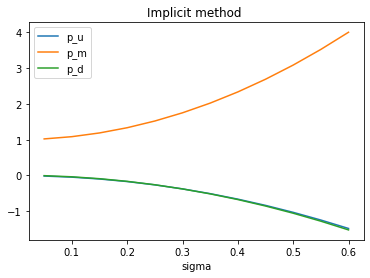

In [197]:
pd.DataFrame({
    'p_u': [-0.5*dt*(s**2/(dx**2) + (r-div-s**2/2)/dx) for s in sigma_range],
    'p_m': [1 + dt*s**2/(dx**2) + r*dt for s in sigma_range],
    'p_d': [-0.5*dt*(s**2/(dx**2) - (r-div-s**2/2)/dx) for s in sigma_range],
    'sigma': sigma_range}).\
    set_index('sigma').plot()
plt.title("Implicit method "); plt.show()

It is interesting to see how both $p_u$ and $p_d$ almost coincide, and decrease as $\sigma$ increases, whereas $p_m$ goes i the opposite direction. Also, **these cannot be interpreted as probabilities** since they reach negative values.

## h) Comparing methods (again)

In [205]:
N = 1000
Nj = int(np.ceil(0.5 * (15*np.sqrt(N/3)-1)))

In [208]:
call = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="call")
put = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="put")
print(f"Explicit:\t call = {round(call, 4)}, put = {round(put, 4)}")

call = implicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="call")
put = implicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="put")
print(f"Implicit:\t call = {round(call, 4)}, put = {round(put, 4)}")

call = crank_nicolson_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="call")
put = crank_nicolson_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, N_timesteps=N, N_xsteps=Nj, option_type="put")
print(f"Crank-Nicolson:\t call = {round(call, 4)}, put = {round(put, 4)}")
print(f"Black-Scholes:\t call = {round(call_bsm, 4)}, put = {round(put_bsm, 4)}")

Explicit:	 call = 9.7236, put = 5.8799
Implicit:	 call = 9.7213, put = 5.8779
Crank-Nicolson:	 call = 9.7224, put = 5.8789
Black-Scholes:	 call = 9.7285, put = 5.8851


Implicit and Crank-Nicolson methods are closer to each other. In this particular situation, the explicit method is closest to the Black-Scholes theoretical value.

## i) Greeks

We will numerically calculate the greeks by approximating the derivatives.
For the Explicit method, we can estimate delta, gamma and theta during the calculation, whereas for vega we use a re-evaluation.

**Obs**: we define theta by normalizing by 252, and normalize vega dividing by 100

In [209]:
def explicit_fd_euro(T, K, S0, r, div, sigma, N_timesteps, N_xsteps, option_type,
                     calculate_greeks=False):
    
    def payoff(s, K):
        if option_type == 'call':
            return max(s-K, 0)
        elif option_type == 'put':
            return max(K-s, 0)
        else:
            raise Exception("Bad option type")
            
    # constants
    dt = T/N_timesteps
    dx = 1.5 * sigma * np.sqrt(3*dt)
    nu = r - div - sigma**2/2
    edx = np.exp(dx)
    pu = dt * (sigma**2/(2*dx**2) + nu/(2*dx))
    pm = 1 - dt * sigma**2/(dx**2) - r*dt
    pd = dt * (sigma**2/(2*dx**2) - nu/(2*dx))
    
    # as we did in the trinomial tree, first build all spot values 
    # since this is a grid, we have no need to evolve them backwards
    St = np.zeros(2*N_xsteps + 1)
    St[0] = S0*np.exp(-N_xsteps*dx)
    for j in range(1,2*N_xsteps+1):
        St[j] = St[j-1]*edx
    
    # boundary values for the option: payoff
    C = np.zeros((N_timesteps+1, 2*N_xsteps+1))
    for j in range(2*N_xsteps+1):
        C[N_timesteps, j] = payoff(St[j], K)
        
    # propagate back
    for i in range(N_timesteps-1, -1, -1):
        
        # finite difference evolution
        for j in range(1, 2*N_xsteps):
            C[i,j] = pu*C[i+1,j+1] + pm*C[i+1,j] + pd*C[i+1,j-1]
        
        # boundary conditions
        if option_type == 'call':
            C[i, 0] = C[i, 1]
            C[i, 2*N_xsteps] = C[i, 2*N_xsteps-1] + (St[2*N_xsteps] - St[2*N_xsteps-1])
        else:
            C[i, 0] = C[i, 1] + (St[1] - St[0])
            C[i, 2*N_xsteps] = C[i, 2*N_xsteps-1] 
            
    # Greeks estimation
    if calculate_greeks:
        j = N_xsteps
        delta = (C[0, j+1] - C[0, j-1])/(St[j+1]-St[j-1])
        gamma = (
            (C[0, j+1] - C[0, j])/(St[j+1]-St[j]) - (C[0, j] - C[0, j-1])/(St[j]-St[j-1])
        )/(0.5 * (St[j+1] - St[j-1]))
        theta = (C[1,j] - C[0,j])/dt
        
        return C[0, j], delta, gamma, theta
            
    return C[0,N_xsteps]

In [210]:
price, delta, gamma, theta = explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=0.2, 
                                              N_timesteps=N, N_xsteps=Nj, option_type="call", calculate_greeks=True)

In [214]:
eps = 1e-3
sigma = 0.2
vega = (
    explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=sigma*(1+eps), N_timesteps=N, N_xsteps=Nj, option_type="call") - \
    explicit_fd_euro(T=1.0, K=100, S0=100, r=0.06, div=0.02, sigma=sigma*(1-eps), N_timesteps=N, N_xsteps=Nj, option_type="call")
)/(2*sigma*eps)

In [226]:
print(f"Price = %.4f" % price)
print(f"Delta = %.4f" % delta)
print(f"Gamma = %.4f" % gamma)
print(f"Theta = %.4f" % (theta/252))
print(f"Vega  = %.4f" % (vega/100))

Price = 9.7236
Delta = 0.6057
Gamma = 0.0187
Theta = -0.0222
Vega  = 0.3736


# Problem 2

## a) Download option data

We will reuse code from HW2 and filter 10 strikes closest to ATM.

In [307]:
pd.set_option('display.max_columns', None)
r = 0.07/100

In [308]:
data = pd.read_csv('../HW2/data_2.csv', index_col=0)
data = data[data['ticker'] == 'AMZN']
data = data[data['maturity'].isin(['2021-03-26', '2021-04-16', '2021-05-21'])]

In [309]:
data['dist_from_ATM'] = np.abs(data['strike'] - data['Close'])
data = data.sort_values(['maturity', 'dist_from_ATM'])
data = data.groupby('maturity').head(10)
data['maturity'].value_counts()

2021-05-21    10
2021-04-16    10
2021-03-26    10
Name: maturity, dtype: int64

In [310]:
data.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,maturity,download_date,time_to_maturity,day_identifier,ticker,Close,Volume,option_price,vol_bisect,calculated_price,dist_from_ATM
4079,AMZN210326C03190000,2021-02-23 19:27:48,3190.0,117.00,113.80,116.20,6.220001,5.614733,19.0,65.0,0.307052,True,REGULAR,USD,call,2021-03-26,2021-02-24,0.083333,DATA_2,AMZN,3194.5,4677222,115.000,0.312538,117.215587,4.5
4222,AMZN210326P03190000,2021-02-23 20:48:39,3190.0,105.27,107.10,109.10,2.109993,2.045359,33.0,90.0,0.300113,False,REGULAR,USD,put,2021-03-26,2021-02-24,0.083333,DATA_2,AMZN,3194.5,4677222,108.100,0.303359,109.158874,4.5
4080,AMZN210326C03200000,2021-02-23 20:57:11,3200.0,111.00,108.65,111.15,3.000000,2.777778,117.0,231.0,0.306419,False,REGULAR,USD,call,2021-03-26,2021-02-24,0.083333,DATA_2,AMZN,3194.5,4677222,109.900,0.314485,113.116320,5.5
4223,AMZN210326P03200000,2021-02-23 20:36:57,3200.0,111.46,111.90,113.95,-12.099998,-9.792812,37.0,231.0,0.299220,True,REGULAR,USD,put,2021-03-26,2021-02-24,0.083333,DATA_2,AMZN,3194.5,4677222,112.925,0.298054,112.386623,5.5
4081,AMZN210326C03205000,2021-02-23 17:07:56,3205.0,86.75,106.15,108.80,-23.390000,-21.236607,2.0,24.0,0.306434,False,REGULAR,USD,call,2021-03-26,2021-02-24,0.083333,DATA_2,AMZN,3194.5,4677222,107.475,0.310219,109.191121,10.5


### b) Option pricing

We will use $N = 2000$ which ensures the error rate.

In [311]:
from tqdm.notebook import tqdm
tqdm.pandas() # for progress bars

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [312]:
N = 2000

In [313]:
data['explicit_price'] = data.progress_apply(lambda row: explicit_fd_euro(T=row['time_to_maturity'], S0=row['Close'], 
                                                                          K=row['strike'], r=0.07/100, sigma=row['vol_bisect'],
                                                                          option_type=row['type'],
                                                                          div=0,
                                                                          N_timesteps=N,
                                                                          N_xsteps=int(np.ceil(row['vol_bisect'] * (15*np.sqrt(N/3)-1)))),
           axis=1)

In [314]:
data['implicit_price'] = data.progress_apply(lambda row: implicit_fd_euro(T=row['time_to_maturity'], S0=row['Close'], 
                                                                          K=row['strike'], r=0.07/100, sigma=row['vol_bisect'],
                                                                          option_type=row['type'],
                                                                          div=0,
                                                                          N_timesteps=N,
                                                                          N_xsteps=int(np.ceil(row['vol_bisect'] * (15*np.sqrt(N/3)-1)))),
           axis=1)

In [315]:
data['crank_nicolson_price'] = data.progress_apply(lambda row: crank_nicolson_fd_euro(T=row['time_to_maturity'], S0=row['Close'], 
                                                                          K=row['strike'], r=0.07/100, sigma=row['vol_bisect'],
                                                                          option_type=row['type'],
                                                                          div=0,
                                                                          N_timesteps=N,
                                                                          N_xsteps=int(np.ceil(row['vol_bisect'] * (15*np.sqrt(N/3)-1)))),
           axis=1)

In [316]:
data[['bid', 'ask', 'explicit_price', 'implicit_price','crank_nicolson_price']].head().round(3)

,bid,ask,explicit_price,implicit_price,crank_nicolson_price
4079,113.80,116.20,117.212,117.198,117.205
4222,107.10,109.10,109.156,109.142,109.149
4080,108.65,111.15,113.117,113.103,113.110
4223,111.90,113.95,112.389,112.375,112.382
4081,106.15,108.80,109.195,109.181,109.188


## c) Calculate Greeks

In [317]:
data = data.reset_index(drop=True)

In [318]:
data['aux'] = data.progress_apply(lambda row: explicit_fd_euro(T=row['time_to_maturity'], S0=row['Close'], 
                                                                          K=row['strike'], r=0.07/100, sigma=row['vol_bisect'],
                                                                          option_type=row['type'],
                                                                          div=0,
                                                                          N_timesteps=N,
                                                                          N_xsteps=int(np.ceil(row['vol_bisect'] * (15*np.sqrt(N/3)-1))),
                                                                          calculate_greeks=True),
           axis=1)

In [319]:
greeks = pd.DataFrame(data['aux'].tolist())
greeks.columns = ['price', 'delta', 'gamma', 'theta']
greeks['theta'] = greeks['theta']/252

In [320]:
eps = 1e-3

In [321]:
greeks['vega'] = data.progress_apply(lambda row: 
                                (explicit_fd_euro(T=row['time_to_maturity'], S0=row['Close'], 
                                                                          K=row['strike'], r=0.07/100, sigma=row['vol_bisect']*(1+eps),
                                                                          option_type=row['type'],
                                                                          div=0,
                                                                          N_timesteps=N,
                                                                          N_xsteps=int(np.ceil(row['vol_bisect'] * (15*np.sqrt(N/3)-1))),
                                                                          calculate_greeks=False) - \
                                 explicit_fd_euro(T=row['time_to_maturity'], S0=row['Close'], 
                                                                          K=row['strike'], r=0.07/100, sigma=row['vol_bisect']*(1-eps),
                                                                          option_type=row['type'],
                                                                          div=0,
                                                                          N_timesteps=N,
                                                                          N_xsteps=int(np.ceil(row['vol_bisect'] * (15*np.sqrt(N/3)-1))),
                                                                          calculate_greeks=False)
                                )/(2*row['vol_bisect']*eps*100),axis=1)     

In [322]:
data = data.join(greeks)

In [323]:
data['mid'] = data[['ask', 'bid']].mean(axis=1)

In [324]:
results = data[['time_to_maturity', 'strike', 'type', 'ask', 'bid', 'mid', 'vol_bisect', 'explicit_price', 'implicit_price', 'crank_nicolson_price']]

In [325]:
results.head()

,time_to_maturity,strike,type,ask,bid,mid,vol_bisect,explicit_price,implicit_price,crank_nicolson_price
0,0.083333,3190.0,call,116.20,113.80,115.000,0.312538,117.212253,117.197876,117.205065
1,0.083333,3190.0,put,109.10,107.10,108.100,0.303359,109.156368,109.142414,109.149392
2,0.083333,3200.0,call,111.15,108.65,109.900,0.314485,113.117484,113.102999,113.110242
3,0.083333,3200.0,put,113.95,111.90,112.925,0.298054,112.388865,112.375140,112.382003
4,0.083333,3205.0,call,108.80,106.15,107.475,0.310219,109.194826,109.180549,109.187688


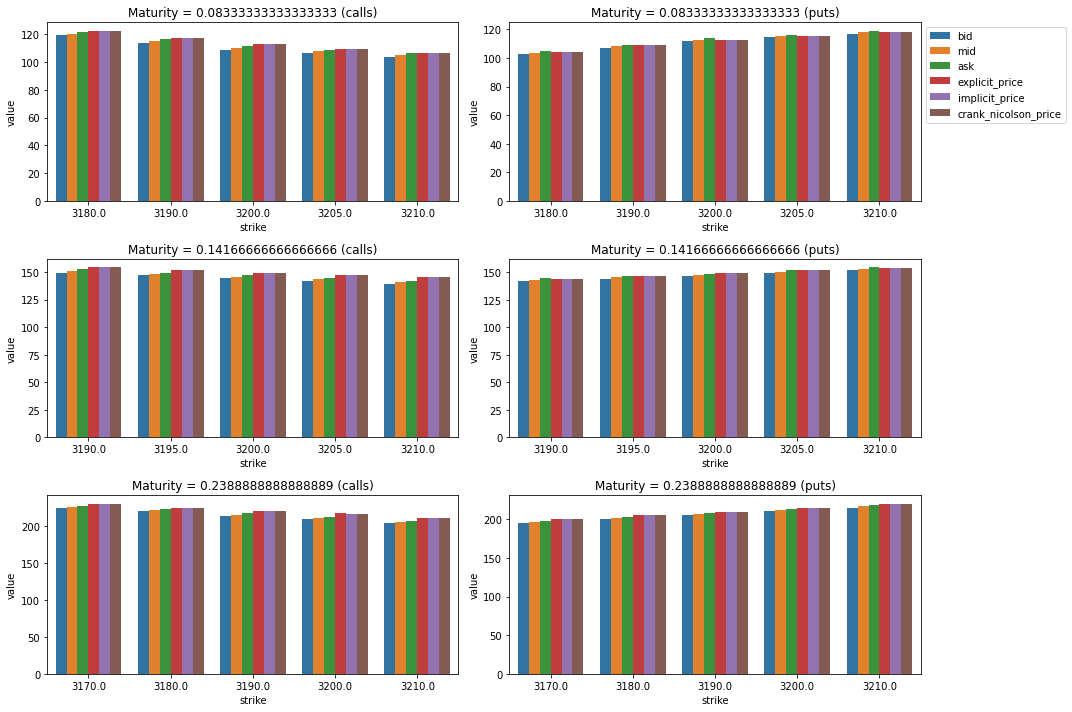

In [326]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10), nrows=3, ncols=2)

for i, maturity in enumerate(results['time_to_maturity'].unique()):
    aux_call = pd.melt(results[(results['time_to_maturity'] == maturity) & (results['type']=='call')],
            id_vars=['strike'], value_vars=['bid', 'mid', 'ask', 'explicit_price', 'implicit_price', 'crank_nicolson_price' ])
    aux_put = pd.melt(results[(results['time_to_maturity'] == maturity) & (results['type']=='put')],
            id_vars=['strike'], value_vars=['bid', 'mid', 'ask', 'explicit_price', 'implicit_price', 'crank_nicolson_price' ])

    # call options
    g = sns.barplot(
        data=aux_call, #kind="bar",
        x="strike", y="value", hue="variable", 
        ax=ax[i,0]
    )
    ax[i,0].get_legend().remove()
    ax[i,0].set_title(f"Maturity = {maturity} (calls)")
    
    # put options
    h = sns.barplot(
        data=aux_put, #kind="bar",
        x="strike", y="value", hue="variable", 
        ax=ax[i,1]
    )
    if i == 0:
        ax[i,1].legend(loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax[i,1].get_legend().remove()
        
    ax[i,1].set_title(f"Maturity = {maturity} (puts)")

plt.tight_layout()
plt.show()

Our methods' prices consistently are higher (lower) than the bid/ask ones for calls (puts), indicating there might be some discrepancies associated with dividends or the choice for the risk-free rate.

# Problem 3

## a) Discretizing

For the PDE

$$\frac{\partial V}{\partial t} + 2 \cos(S) \frac{\partial V}{\partial S} + 0.2 S^{3/2} \frac{\partial^2 V}{\partial S^2} - rV  0$$

let us call $\mu(S) = 2\cos(S)$ and $\sigma(S) = 0.2 S^{3/2}$. The under the explicit scheme, same as before

$$\begin{align*}
\frac{\partial V}{\partial t} (i,j) &= \frac{V_{i+1,j} - V_{i,j}}{\Delta t}\\
\frac{\partial V}{\partial S} (i,j) &= \frac{V_{i+1,j+1} - V_{i+1,j-1}}{2 \Delta S}\\
\frac{\partial^2 V}{\partial S^2} (i,j) &= \frac{V_{i+1,j+1} - 2 V_{i+1,j} + V_{i+1,j-1}}{\Delta S^2}
\end{align*}$$


We shall also write $S = j \Delta S$, such that 
$$\mu_{i,j} = 2 \cos (j \Delta S)$$
$$\sigma_{i,j} = 0.2 (j \Delta S)^{3/2}$$

Putting everything together we get
$$\frac{V_{i+1,j} - V_{i,j}}{\Delta t} + \mu_{i,j} \frac{V_{i+1,j+1} - V_{i+1,j-1}}{2 \Delta S} + \sigma_{i,j} \frac{V_{i+1,j+1} - 2 V_{i+1,j} + V_{i+1,j-1}}{\Delta S^2}$$

$$\frac{V_{i,j}}{\Delta t } = \left[
V_{i+1,j+1} \left( \frac{\mu_{ij}}{2\Delta S} + \frac{\sigma_{ij}}{\Delta S^2} \right) + 
V_{i+1,j} \left(\frac{1}{\Delta t} - \frac{2 \sigma_{ij}}{\Delta S^2}\right) +
V_{i+1,j-1} \left( -\frac{\mu_{ij}}{2\Delta S} + \frac{\sigma_{ij}}{\Delta S^2} \right) 
\right]$$

$$\boxed{V_{i,j} = p_u V_{i+1, j+1} + p_m V_{i+1,j} + p_d V_{i+1,j-1}}$$
where

$$\boxed{\begin{align*}
p_u &= \Delta t \left( \frac{\mu_{ij}}{2\Delta S} + \frac{\sigma_{ij}}{\Delta S^2} \right)\\
p_m &= \Delta t \left(\frac{1}{\Delta t} - \frac{2 \sigma_{ij}}{\Delta S^2}\right)\\
p_d &= \Delta t \left( -\frac{\mu_{ij}}{2\Delta S} + \frac{\sigma_{ij}}{\Delta S^2} \right)
\end{align*}}$$

**Notice how the coefficients are $j$-dependent** since $\mu$ and $\sigma$ are functions of $j$.

## b) Boundary conditions

Any call option must satisfy, regardless of the underlying dynamics, that:
* Value at maturity must be the payoff
* Value for high $S$ should be asymptotically equal to it, meaning a von Neumann boundary condition = 1
* The call option's value cannot be lower than the asset itself, which is bounded below at 0. Thus there is a Dirichlet boundary condition = 0 at $S=0$.